# Model comparison



## Setup

In [7]:
import os
import sys
import dotenv
import json
from loguru import logger

# Append the models path in order to import the models
PROJECT_ROOT = os.path.join(os.getcwd(), 'src/')
print(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

# Load env variables
dotenv.load_dotenv()

# Set log level INFO
logger.remove()
logger.add(sys.stderr, level="INFO")

/home/twanh/workspace/thesis/thesis-advent-of-agents/src/


4

In [8]:
# Import models from the system
from models.base_model import BaseLanguageModel
from models.gemini_model import GeminiLanguageModel
from models.openai_model import OpenAILanguageModel
from models.deepseek_model import DeepseekLanguageModel

### Load puzzles and input/outputs

In [69]:
# Get the correct paths
test_data_folder = os.path.join(PROJECT_ROOT, '..', 'experiments', 'test_data')
puzzles_folder = os.path.join(test_data_folder, 'puzzles/')
input_output_file = os.path.join(test_data_folder, 'answers2024.json')
puzzle_files = [os.path.join(puzzles_folder, f) for f in os.listdir(puzzles_folder) if os.path.isfile(os.path.join(puzzles_folder, f))]

In [70]:
# Create a datastructure were we can get by day
json_data = {}
with open(input_output_file, 'r') as f:
    json_data = {item['day']: item for item in json.load(f)}

puzzle_data = []
for file_path in puzzle_files:
    # Get the day of the puzzle file
    file_name = os.path.basename(file_path)
    day_str = file_name.split('_')[-1].split('.')[0]
    day = int(day_str)

    if day in json_data:
        with open(file_path, 'r') as f:
            puzzle_description = f.read()

        puzzle_info = {
            "year": json_data[day]['year'],
            "day": day,
            "description": puzzle_description,
            "input": json_data[day]['input'],
            "expected_output": json_data[day]['part1']
        }

        puzzle_data.append(puzzle_info)

# Sort by day
puzzle_data.sort(key=lambda x: x['day'])
print(len(puzzle_data)) # should be 25

25


### Model Configurations

| Agent          | Configuration 1 (Ultimate Power) | Configuration 2 (Pre-AOC Power) | Configuration 3 (Reasoning Focus) | Configuration 4 (Speed Optimized) | Configuration 5 (P&D Reasoning) | Configuration 6 (Balanced Mix) |
| :------------- | :------------------------------ | :------------------------------ | :-------------------------------- | :------------------------------- | :------------------------------ | :----------------------------- |
| **preprocessing** | Claude 3.5 Sonnet               | Claude 3.5 Sonnet               | o3-mini (Reasoning)               | Claude 3.5 Haiku                  | GPT-4o mini                     | GPT-4o mini                     |
| **retrieval**  | Gemini 2.5 Pro                  | GPT-4.1                        | o4-mini (Reasoning)               | Gemini 2.0 Flash                 | Gemini 2.0 Flash                | Claude 3.5 Sonnet               |
| **planning**   | o3 (Reasoning)                  | o4-mini (Reasoning)            | o4-mini (Reasoning)               | GPT-4o mini                      | o4-mini (Reasoning)             | GPT-4.1                         |
| **coding**     | GPT-4.1                         | GPT-4.1                        | o3-mini (Reasoning)               | Gemini 2.0 Flash                 | GPT-4.1                         | Gemini 2.0 Flash                |
| **debugging**  | Claude 3.7 Sonnet               | o3-mini (Reasoning)            | o4-mini (Reasoning)               | o3-mini (Reasoning)              | o3-mini (Reasoning)             | o4-mini (Reasoning)             |

##### Ultimate Power
Aim: Achieve maximum possible performance by strategically deploying the most powerful models where they matter most.
Strategy: Places o3 (the most powerful reasoning model) in Planning where complex problem decomposition is critical. Uses elite models for each other role, pairing Claude 3.7 Sonnet's strong analytical abilities with debugging, and GPT-4.1's code generation excellence with the coding agent. Balanced across providers to leverage each company's strengths.

##### Pre-AOC Power
Aim: Maximize performance while controlling for potential AOC training data advantage.
Strategy: Deliberately excludes Gemini 2.5 models which may have seen AOC 2024 data. Still achieves high capability with Claude 3.5 Sonnet for preprocessing, GPT-4.1 for retrieval and coding, and reasoning-capable models strategically placed for planning (o4-mini) and debugging (o3-mini).

##### Reasoning Focus
Aim: Evaluate whether reasoning-flagged models throughout the entire pipeline significantly improve performance.
Strategy: Uses only models with explicit reasoning capabilities for all agent roles. Balances o3-mini (one use for coding) with o4-mini across other roles, creating a pipeline entirely focused on reasoning capabilities. Will reveal if reasoning throughout is worth the potential cost increase.

##### Speed Optimized
Aim: Maximize speed while maintaining robust performance on complex puzzles.
Strategy: Employs the fastest models in the collection (Haiku, Flash, mini variants) while reserving reasoning capabilities (o3-mini) only for debugging where errors are most critical to resolve quickly. Uses the speed of Gemini 2.0 Flash for coding while ensuring planning is still effective with GPT-4o mini.

#### P&D Reasoning
Aim: Test the hypothesis that reasoning capabilities mainly benefit Planning and Debugging.
Strategy: Concentrates reasoning models only in Planning and Debugging roles, using capable but non-reasoning models elsewhere. If this configuration performs nearly as well as the Reasoning Focus configuration but with lower cost/latency, it indicates that reasoning is most valuable in these specific roles.

#### Balanced Mix
Aim: Create a balanced, cost-effective pipeline using strengths from each provider.
Strategy: Distributes roles across providers to leverage each company's strengths: Google for fast coding, OpenAI for planning and debugging, and Claude for context-handling in retrieval. Avoids using the most expensive models while maintaining good coverage of capabilities across the pipeline.

In [ ]:
from main import _get_model

# Configuration 1 (Ultimate Power)
config_ultimate_power = {
    "preprocessing": _get_model("claude-3-5-sonnet-20241022"),
    "retrieval": _get_model("gemini-2.5-pro-preview-05-06"),
    "planning": _get_model("o3"),  # Reasoning
    "coding": _get_model("gpt-4.1-2025-04-14"),
    "debugging": _get_model("claude-3-7-sonnet-20250219"),
}

# Configuration 2 (Speed)
config_speed = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("claude-3-5-haiku-20241022"),
    "coding": _get_model("claude-3-5-haiku-20241022"),
    "debugging": _get_model("gemini-2.0-flash"),
}

# Configuration 3 (Coding Reasoning)
config_coding_reasoning = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("gemini-2.0-flash"),
    "coding": _get_model("gemini-2.0-flash-thinking-exp-1219"),  # Reasoning
    "debugging": _get_model("gemini-2.0-flash"),
}

# Configuration 4 (Planning Reasoning)
config_planning_reasoning = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("gemini-2.0-flash-thinking-exp-1219"),  # Reasoning
    "coding": _get_model("gemini-2.0-flash"),
    "debugging": _get_model("gemini-2.0-flash"),
}

# Dictionary collecting all configurations for testing
configurations_to_test = {
    #"ultimate_power": config_ultimate_power,
    "speed": config_speed,
    "coding_reasoning": config_coding_reasoning,
    "planning_reasoning": config_planning_reasoning,
}

print(configurations_to_test)


## System

In [72]:
from agents.base_agent import BaseAgent
from agents.coding_agent import CodingAgent
from agents.debugging_agent import DebuggingAgent
from agents.planning_agent import PlanningAgent
from agents.pre_processing_agent import PreProcessingAgent
from agents.retreival_agent import RetrievalAgent
from core.orchestrator import Orchestrator
from utils.util_types import AgentSettings
from core.state import MainState
from utils.util_types import Puzzle

In [73]:

def setup_system(config: dict[str, BaseLanguageModel], expected_output: str, puzzle_input: str):

    preprocessing_model = config["preprocessing"]
    retrieval_model = config["retrieval"]
    planning_model = config["planning"]
    coding_model = config["coding"]
    debugging_model = config["debugging"]

    agents = (
        (
            PreProcessingAgent(
                'preprocess', model=preprocessing_model,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            RetrievalAgent(
                'retreival',
                model=retrieval_model,
                connection_string=os.getenv('DB_CONNECTION_STRING') or '',
                openai_key=os.getenv('OPENAI_API_KEY') or '',
                weights=None, # Use default weights
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            PlanningAgent(
                'planning',
                model=planning_model,
                n_plans=3, # Keep n_plans fixed for consistent comparison
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            CodingAgent('coding', model=coding_model),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            DebuggingAgent(
                'debugging',
                model=debugging_model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            ),
            AgentSettings(enabled=True, can_debug=True),
        ),
    )

    orchestrator = Orchestrator(agents, {})
    return orchestrator


In [ ]:
import time
def run_and_test_system(
    day: int,
    puzzle_desc: str,
    puzzle_input: str,
    expected_output: str,
    config: dict 
) -> dict[str, str|int|None]:

    orchestrator = setup_system(
        config,
        expected_output=expected_output,
        puzzle_input=puzzle_input
    )


    puzzle = Puzzle(
        description=puzzle_desc,
        solution=None,
        year=2024,
        day=day,
    )

    state = MainState(puzzle=puzzle)

    try:
        start_time = time.time()
        ret_state = orchestrator.solve_puzzle(state)
        end_time = time.time()
        return {
            'success': ret_state.is_solved,
            'day': day,
            'code': ret_state.final_code,
            'debug_attempts': ret_state.debug_attempts,
            'debug_suggestions': ret_state.debug_suggestions,
            'n_retreived_puzzles': len(ret_state.retreived_puzzles),
            'keywords': ','.join(ret_state.keywords),
            'concepts': ','.join(ret_state.underlying_concepts),
            'time': end_time - start_time
        }

    except Exception as e:
        print(f"Runtime error during puzzle solving for Day {day}: {e}")
        return {
            'success': False,
            'code': None,
            'day': day,
            'debug_attempts': None,
            'debug_suggestions': None,
            'n_retreived_puzzles': None,
            'keywords': None,
            'concepts': None,
            'time': None,
        }

In [75]:
import datetime
import pandas as pd
SAVE_DIR = os.path.join(PROJECT_ROOT, '../', 'experiments/', 'results/', 'model_comparison/')

def run_config(config: dict[str, BaseLanguageModel], config_name: str, puzzle_data):

    all_results = []
    for puzzle in puzzle_data:
        # Load puzzle
        puzzle_day = puzzle['day']
        puzzle_description = puzzle['description']
        input_ = puzzle['input']
        expected_ouptut = puzzle['expected_output']
        print(f"Running day {puzzle_day}")

        # RUn the tests
        results = run_and_test_system(
            puzzle_day,
            puzzle_description,
            input_,
            expected_ouptut,
            config,
        )

        results['config_name'] = config_name
        all_results.append(results)

    # Save the resu
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'comp-{config_name}-{timestamp}.csv'
    filepath =os.path.join(SAVE_DIR, filename)

    results_df = pd.DataFrame(all_results)
    print(f"Saving results for {config_name} to {filepath}")
    results_df.to_csv(filepath, index=False)
    
    return results_df

In [ ]:
# Runn all configs

results_list = []
for config_name, config in configurations_to_test.items():

    print(f"----- Running config {config_name}")
    print(config)
    results_config = run_config(config, config_name, puzzle_data)
    results_list.append(results_config)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'all_configs-{timestamp}.csv'
filepath = os.path.join(SAVE_DIR, filename)
results = pd.concat(results_list)
results.to_csv(filepath, index=False)

----- Running config pre_aoc_power
{'preprocessing': <models.anthropic_model.AnthropicLanguageModel object at 0x704d852b96d0>, 'retrieval': <models.openai_model.OpenAILanguageModel object at 0x704d852bb1d0>, 'planning': <models.openai_model.OpenAILanguageModel object at 0x704d852dea80>, 'coding': <models.openai_model.OpenAILanguageModel object at 0x704d852d3560>, 'debugging': <models.openai_model.OpenAILanguageModel object at 0x704d852c29f0>}
Running day 1


2025-05-20 20:36:10.090 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 20:36:10.103 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-20 20:36:20.064 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:37:08.787 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 8 column 5 (char 1739)')
2025-05-20 20:37:08.789 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-20 20:38:06.208 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:38:06.213 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:38:06.215 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:38:21.283 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:38:44.117 

Running day 2


2025-05-20 20:39:34.152 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:40:27.039 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:40:27.042 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:40:27.043 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:40:55.090 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:41:20.383 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 20:41:39.274 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nIterate over each report (one per line), parse it into a list of integers, compute the list of adjacent differences, then check whether those differences are all strictly positive (and ≤ 3) or all strictly negative (and ≥ −3). Count how many repo

Running day 3


2025-05-20 20:42:06.423 | ERROR    | agents.pre_processing_agent:process:76 - Error parsing JSON: Invalid control character at: line 4 column 121 (char 320)
2025-05-20 20:42:06.425 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for preprocess
2025-05-20 20:42:14.554 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:42:36.182 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-20 20:42:36.207 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-20 20:42:36.210 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:42:36.211 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:42:36.212 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:43:32.787 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
20

Running day 4


2025-05-20 20:45:24.740 | ERROR    | agents.pre_processing_agent:process:76 - Error parsing JSON: Invalid control character at: line 37 column 100 (char 1548)
2025-05-20 20:45:24.742 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for preprocess
2025-05-20 20:45:34.031 | ERROR    | agents.pre_processing_agent:process:76 - Error parsing JSON: Invalid control character at: line 32 column 98 (char 1433)
2025-05-20 20:45:34.033 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for preprocess
2025-05-20 20:45:44.165 | ERROR    | agents.pre_processing_agent:process:76 - Error parsing JSON: Invalid control character at: line 38 column 93 (char 1439)
2025-05-20 20:45:44.174 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 3/3 for preprocess
2025-05-20 20:45:53.488 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:46:52.889 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: pla

Running day 5


2025-05-20 20:48:32.483 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:49:42.152 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:49:42.157 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:49:42.160 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:50:00.168 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:50:19.423 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 20:50:42.571 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 20:51:08.400 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 20:51:08.406 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 20:51:08.410 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 20:51:08.495 | INFO     | agents.debugging_

Running day 6


2025-05-20 20:51:19.738 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:52:14.546 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:52:14.550 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:52:14.553 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:52:31.539 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:53:00.499 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 20:53:25.597 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 20:53:44.245 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 20:53:44.248 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 20:53:44.253 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 20:53:44.311 | INFO     | agents.debugging_

Running day 7


2025-05-20 20:53:52.826 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:54:49.767 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:54:49.779 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:54:49.781 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:55:09.672 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:55:35.027 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 20:56:05.131 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 20:56:15.062 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 20:56:15.062 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 20:56:15.065 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 20:56:15.474 | INFO     | agents.debugging_

Running day 8


2025-05-20 20:56:25.403 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 20:56:45.602 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle22-2016. Skipping...
2025-05-20 20:57:07.925 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 20:57:07.939 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 20:57:07.941 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 20:57:55.114 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 20:58:28.661 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nGroup all antennas by their frequency.  For each frequency group of size ≥ 2, consider every unordered pair of antennas and compute the two _external_ division points on the line through them where one ante

Running day 9


2025-05-20 21:00:05.055 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:00:07.614 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle2-2017. Skipping...
2025-05-20 21:00:07.643 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2016. Skipping...
2025-05-20 21:00:07.666 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2017. Skipping...
2025-05-20 21:00:07.668 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:00:07.670 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:00:07.671 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:00:38.950 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:01:01.672 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:01:37.525 | WARNING  | agents.plan

Running day 10


2025-05-20 21:04:42.611 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:04:44.756 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-20 21:05:18.853 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:05:18.856 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:05:18.858 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:05:44.546 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:06:16.873 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:06:50.509 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:07:25.694 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:07:25.696 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 2

Running day 11


2025-05-20 21:07:35.078 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:08:35.478 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-20 21:08:35.489 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:08:35.490 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:08:35.492 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:08:56.414 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:09:29.987 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:09:52.788 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:10:04.815 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:10:04.821 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 21

Running day 12


2025-05-20 21:11:26.228 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:12:35.813 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:12:35.818 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:12:35.821 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:13:00.227 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:13:35.264 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:13:54.502 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nUse a flood-fill (connected-component) algorithm to find every region of identical letters in the grid. For each region, count its area (number of cells) and its perimeter (sum of missing or mismatched neighbors across its cells). Compute the pri

Running day 13


2025-05-20 21:14:34.111 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:14:37.229 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-20 21:15:13.666 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:15:13.669 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:15:13.671 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:15:42.845 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:16:09.160 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:16:33.438 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:16:46.956 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:16:46.958 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 2

Running day 14


2025-05-20 21:16:57.291 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:17:25.661 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 8 column 5 (char 1479)')
2025-05-20 21:17:25.664 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-20 21:18:29.557 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:18:29.559 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:18:29.561 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:19:13.388 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:19:39.884 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:19:54.751 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from respons

Running day 15


2025-05-20 21:20:30.582 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:20:59.098 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle8-2016. Skipping...
2025-05-20 21:21:11.591 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:21:11.593 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:21:11.594 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:21:40.398 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nSimulate the robot (`@`) and boxes (`O`) on the 2D grid step by step. For each move command, check the adjacent cell in that direction:  \n- If it is empty (`.`), move the robot.  \n- If it is a box (`O`) and the cell beyond it is empty, push the box then move the robot.  \n- Otherwise (wall `#`, 

Running day 16


2025-05-20 21:30:03.026 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:30:26.654 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-20 21:30:42.337 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:30:42.339 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:30:42.341 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:31:13.976 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:31:46.457 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:32:04.567 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:32:38.987 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:32:38.988 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 2

Running day 17


2025-05-20 21:32:52.795 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:33:15.703 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2016. Skipping...
2025-05-20 21:33:34.482 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:33:34.484 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:33:34.486 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:34:05.602 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:34:31.713 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:35:09.301 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:35:55.694 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:35:55.696 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 2

Running day 18


2025-05-20 21:36:06.745 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:36:10.903 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-20 21:36:43.417 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:36:43.422 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:36:43.425 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:37:02.222 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:37:26.104 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 21:38:00.412 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 21:38:19.791 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 21:38:19.794 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 2

Running day 19


2025-05-20 21:38:28.980 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:39:09.060 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-20 21:39:09.063 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:39:09.065 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:39:09.065 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:39:30.323 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 21:39:44.308 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nFor each desired design string, perform a classic "word‐break" dynamic programming check against the set of available patterns. Maintain a boolean DP array where `dp[i]` is true if the prefix of length `i` 

Running day 20


2025-05-20 21:40:51.403 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 21:40:54.043 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-20 21:41:46.313 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 21:41:46.318 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 21:41:46.320 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 21:42:10.163 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="```markdown\n## 1. Overall Approach\nPrecompute the shortest “normal” path distances between every pair of track cells (cells marked `.` or `S` or `E`) using BFS on the grid respecting walls. Then, for each track cell `i`, enumerate all track cells `j` reachable in exactly two moves when ignoring walls (a “cheat” segment). For each 

## Analysis

### Setup and Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
RESULTS_DIR = os.path.join(PROJECT_ROOT, '../', 'experiments/', 'results/', 'model_comparison/')

In [16]:
# The first run did not save the day
# However the index+1 is the day since days are sorted
file_name = 'comp-ultimate_power-20250520_162430.csv' 
file_path = os.path.join(RESULTS_DIR, file_name)

# Add day column which is index + 1
wrong_df = pd.read_csv(file_path)
wrong_df['day'] = wrong_df.index + 1
wrong_df.head()

# Save the file
out_file_name = 'comp-ultimate_power-fix-20250520_162430.csv' 
out_file_path = os.path.join(RESULTS_DIR, out_file_name)
wrong_df.to_csv(out_file_path, index=False)


In [23]:
# Load all the individual run files and combine them into one dataframe
result_files = (
    'comp-ultimate_power-fix-20250520_162430.csv', # Ultimate power (first run)
)

df_list = []
for file in result_files:
    loaded = pd.read_csv(os.path.join(RESULTS_DIR, file))
    df_list.append(loaded)

df = pd.concat(df_list)
df.head()

,success,code,debug_attempts,debug_suggestions,n_retreived_puzzles,keywords,concepts,time,config_name,day
0,True,"""""""\nAdvent of Code Day 1: Historian Hysteria ...",0,[],1,"array processing,sorting,numerical computation...","array sorting,pair matching,absolute differenc...",468.263707,ultimate_power,1
1,True,"""""""\nAdvent of Code 2020 Day 2: Red-Nosed Repo...",0,[],2,"sequence validation,number sequence,array proc...","array traversal,monotonic sequence checking,ad...",426.343337,ultimate_power,2
2,True,"""""""\nAdvent of Code Day 3: Mull It Over\nParse...",0,[],1,"string parsing,pattern matching,arithmetic,inp...","regular expressions,string manipulation,input ...",297.929070,ultimate_power,3
3,True,"""""""\nAdvent of Code - Ceres Search (Find all ""...",0,[],3,"grid,2D array,pattern matching,string search,d...","grid traversal,pattern matching,directional se...",737.338779,ultimate_power,4
4,True,"""""""\nAdvent of Code 2023 Day 5: Print Queue\nS...",0,[],2,"topological sorting,sequence validation,depend...","directed graph,dependency checking,cycle detec...",501.047329,ultimate_power,5


### Analyze the results

#### Success Rate By Configuration

Success Rates by Configuration:
    Configuration  Success Rate  Number of Puzzles
0  ultimate_power          96.0                 25


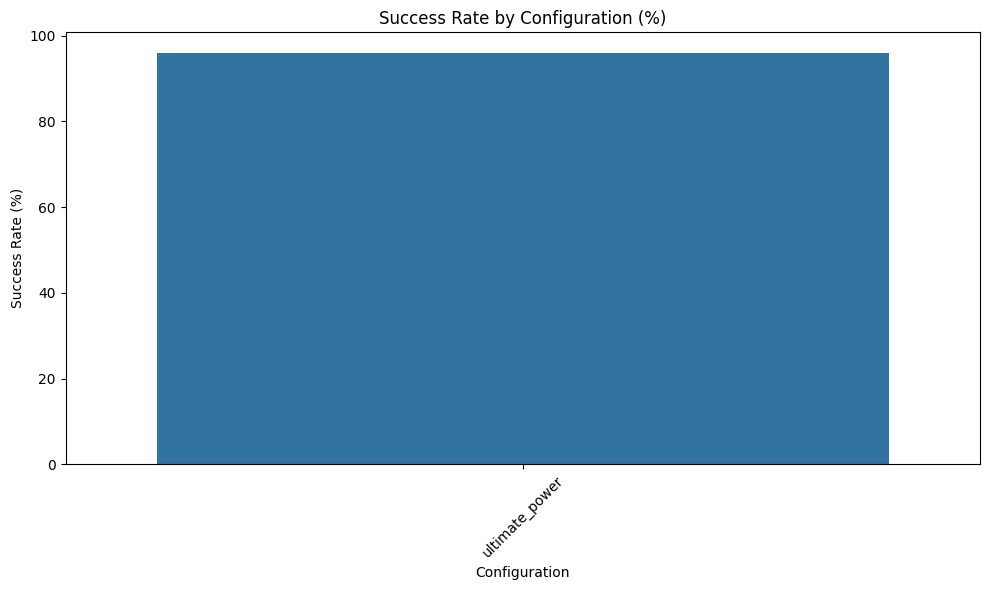

In [25]:
# Calculate success rates by configuration
success_by_config = df.groupby('config_name')['success'].agg(['mean', 'count']).reset_index()
success_by_config.columns = ['Configuration', 'Success Rate', 'Number of Puzzles']
success_by_config['Success Rate'] = success_by_config['Success Rate'] * 100  # Convert to percentage

# Display the results
print("Success Rates by Configuration:")
print(success_by_config)

# Plot success rates
plt.figure(figsize=(10, 6))
sns.barplot(x='Configuration', y='Success Rate', data=success_by_config)
plt.title('Success Rate by Configuration (%)')
plt.ylabel('Success Rate (%)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Time 

Time Performance by Configuration (seconds):
    Configuration  Mean Time  Median Time    Std Dev   Min Time     Max Time
0  ultimate_power  706.41403   633.299987  332.03326  297.92907  1495.440613


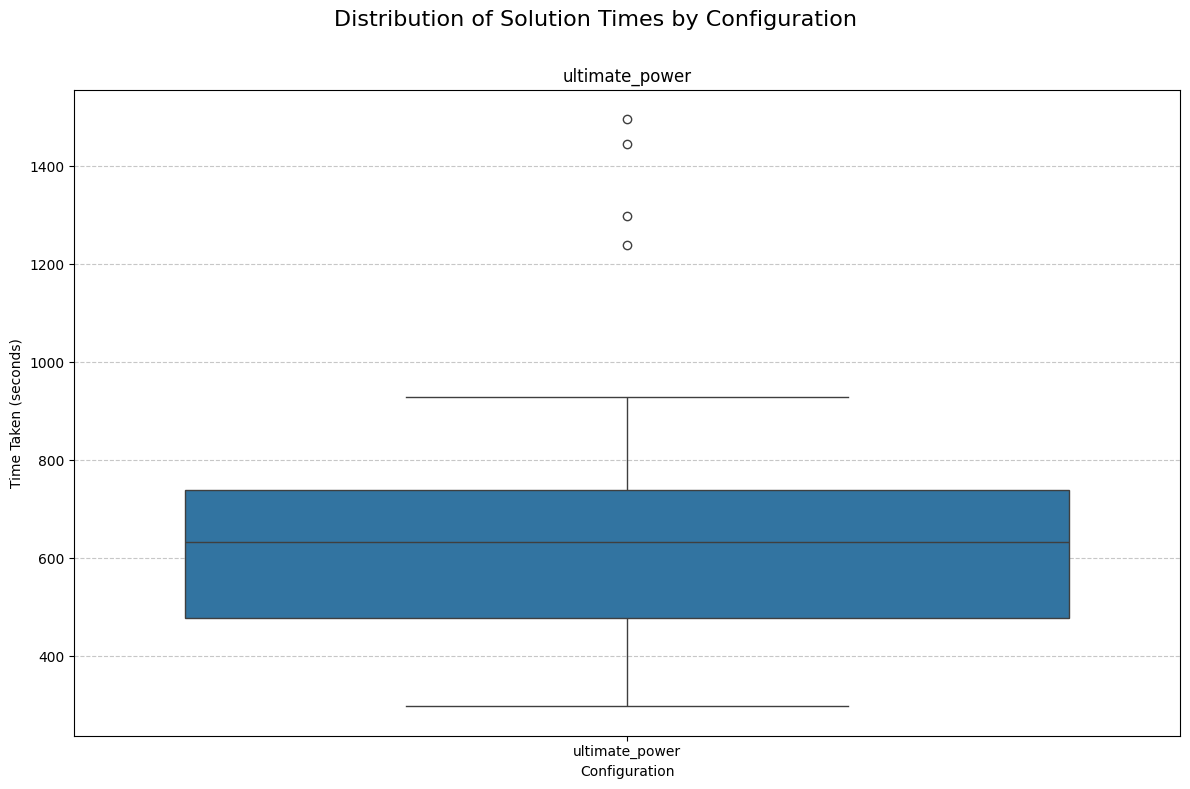

In [31]:
# Time analysis by configuration
time_by_config = df.groupby('config_name')['time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
time_by_config.columns = ['Configuration', 'Mean Time', 'Median Time', 'Std Dev', 'Min Time', 'Max Time']

# Display the results
print("Time Performance by Configuration (seconds):")
print(time_by_config)

# Create boxplots for each model
plt.figure(figsize=(12, 8))
for i, config_name in enumerate(df['config_name'].unique()):
    plt.subplot(1, len(df['config_name'].unique()), i+1)
    
    config_data = df[df['config_name'] == config_name]
    sns.boxplot(x='config_name', y='time', data=config_data)
    plt.title(f'{config_name}')
    
    if i == 0:  # Only add y-label to the first subplot
        plt.ylabel('Time Taken (seconds)')
    else:
        plt.ylabel('')
    
    plt.xlabel('Configuration')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Solution Times by Configuration', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### Debug Attempts


--- Average Debug Attempts per Configuration ---
config_name
ultimate_power    0.44
Name: debug_attempts, dtype: float64


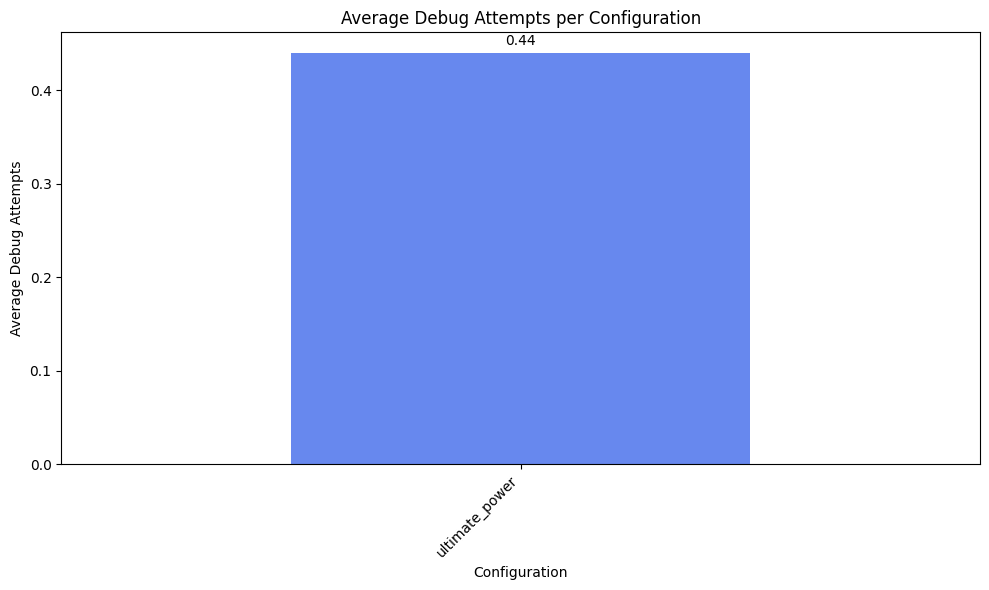

In [33]:
# Calculate average debug attempts per configuration (for all attempts)
avg_debug_attempts_per_config = (
    df.groupby("config_name")["debug_attempts"].mean().sort_values()
)

print("\n--- Average Debug Attempts per Configuration ---")
print(avg_debug_attempts_per_config)

# Plotting
plt.figure(figsize=(10, 6))
avg_debug_attempts_per_config.plot(
    kind="bar", color=sns.color_palette("coolwarm")
)
plt.title("Average Debug Attempts per Configuration")
plt.ylabel("Average Debug Attempts")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")
# Add attempt labels on top of bars
for i, v in enumerate(avg_debug_attempts_per_config):
    plt.text(i, v + (0.02 * avg_debug_attempts_per_config.max()), f"{v:.2f}", color="black", ha="center")

plt.tight_layout()
plt.show()

#### Retrieval


--- Average Number of Retrieved Puzzles per Configuration ---
config_name
ultimate_power    1.68
Name: n_retreived_puzzles, dtype: float64


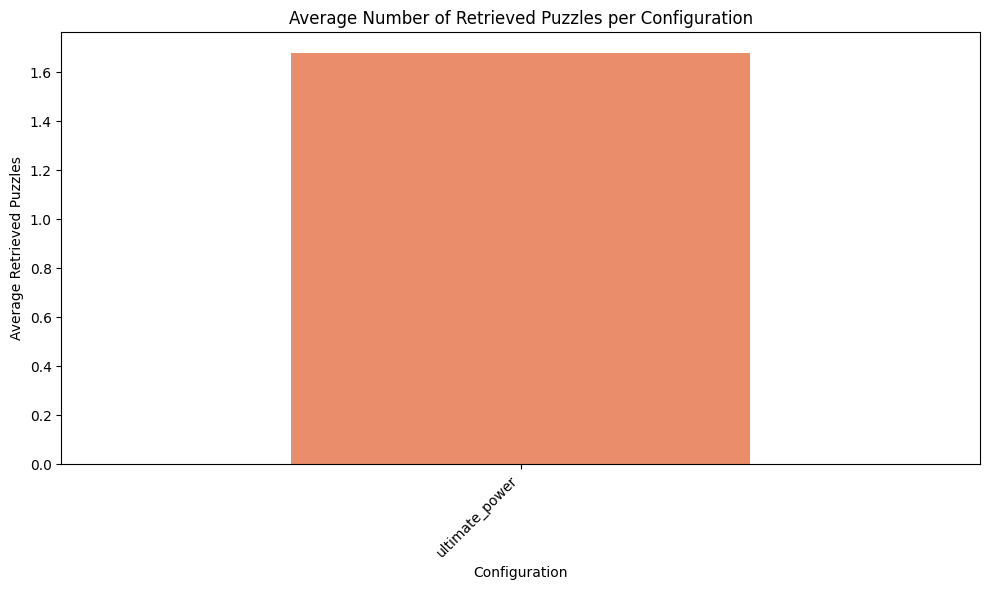


Overall correlation between n_retreived_puzzles and success: 0.17


In [34]:
# Average number of retrieved puzzles per configuration
avg_retrieved_per_config = (
    df.groupby("config_name")["n_retreived_puzzles"].mean().sort_values()
)

print("\n--- Average Number of Retrieved Puzzles per Configuration ---")
print(avg_retrieved_per_config)

plt.figure(figsize=(10, 6))
avg_retrieved_per_config.plot(kind="bar", color=sns.color_palette("flare"))
plt.title("Average Number of Retrieved Puzzles per Configuration")
plt.ylabel("Average Retrieved Puzzles")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Correlation between n_retreived_puzzles and success (overall)
# Note: This is a simple correlation; causation is not implied.
# Convert boolean 'success' to int for correlation
correlation_retrieved_success = df["n_retreived_puzzles"].corr(
    df["success"].astype(int)
)
print(
    f"\nOverall correlation between n_retreived_puzzles and success: {correlation_retrieved_success:.2f}"
)

#### Puzzle Difficulty




--- Success Rate per Puzzle (Across All Configurations) ---
day
21    0.0
1     1.0
3     1.0
2     1.0
5     1.0
6     1.0
7     1.0
4     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
8     1.0
16    1.0
17    1.0
19    1.0
18    1.0
20    1.0
22    1.0
23    1.0
24    1.0
25    1.0
Name: success, dtype: float64


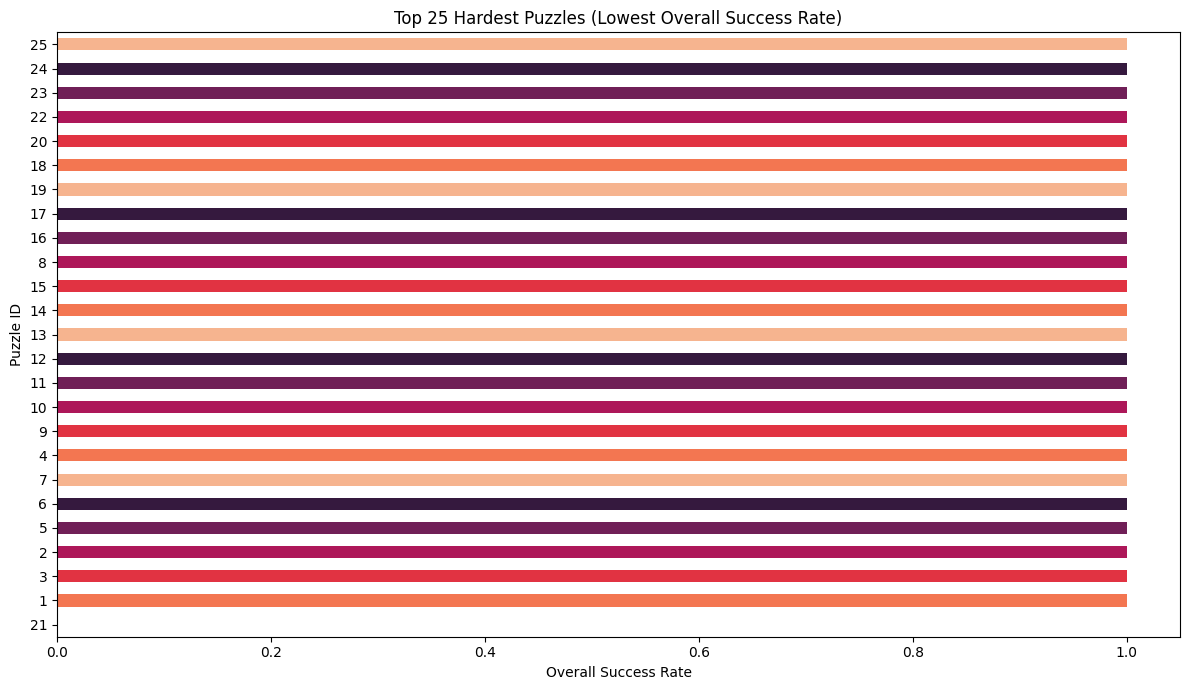

In [37]:
# Success rate per puzzle_id
puzzle_success_rate = (
    df.groupby("day")["success"].mean().sort_values()
) # Sorts by least successful to most

print("\n--- Success Rate per Puzzle (Across All Configurations) ---")
print(puzzle_success_rate)

# Plotting top N hardest puzzles
N_PUZZLES_TO_SHOW = 25 # Adjust as needed
plt.figure(figsize=(12, 7))
puzzle_success_rate.head(N_PUZZLES_TO_SHOW).plot(
    kind="barh", color=sns.color_palette("rocket_r")
)
plt.title(f"Top {N_PUZZLES_TO_SHOW} Hardest Puzzles (Lowest Overall Success Rate)")
plt.xlabel("Overall Success Rate")
plt.ylabel("Puzzle ID")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
df_pivot = df.pivot_table(
    index="day",
    columns="confi_name",
    values="success",
    aggfunc="mean", 
    fill_value=np.nan 
)
df_pivot = df_pivot.astype(float) # Ensure values are float for heatmap

print("\n--- Configuration Performance on Specific Puzzles (1=Success, 0=Fail, NaN=Not Attempted) ---")
print(df_pivot)

plt.figure(figsize=(12, max(6, len(df_pivot) * 0.5))) # Adjust height based on number of puzzles
sns.heatmap(
    df_pivot,
    annot=True,
    cmap="RdYlGn", # Red-Yellow-Green: Red for fail, Green for success
    linewidths=0.5,
    linecolor="gray",
    cbar=True,
    vmin=0, # Explicitly set color scale from 0
    vmax=1  # to 1
)
plt.title("Success of Configurations per Puzzle")
plt.ylabel("Puzzle ID")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


KeyError: 'puzzle_id'